Da es bei der SVM-Variante von OpenCV nicht möglich war W'keiten auszugeben. Wurde hier mit der Variante von scikit-learn versucht eine bessere Lösung zu findnen. Jedoch haben wir auch hier keine andere Option gefunden und bleiben deshalb bei der Variante von OpenCV.

In [1]:
import cv2 as cv
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import time
from sklearn import svm

SZ=20
bin_n = 16 # Number of bins

Path = 'D:\Schule\PREN\Bilder'
TrainingImg = '\digits.png'
TestImg = '\ZahlenSchwarzAufWeiss.jpg'

affine_flags = cv.WARP_INVERSE_MAP|cv.INTER_LINEAR

## [deskew]
def deskew(img):
    m = cv.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img
## [deskew]

## [hog]
def hog(img):
    gx = cv.Sobel(img, cv.CV_32F, 1, 0)
    gy = cv.Sobel(img, cv.CV_32F, 0, 1)
    mag, ang = cv.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...16)
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)     # hist is a 64 bit vector

    # transform to Hellinger kernel
    eps = 1e-7
    hist /= hist.sum() + eps
    hist = np.sqrt(hist)
    hist /= norm(hist) + eps
    return hist
## [hog]

img = cv.imread(Path+TrainingImg,0)
if img is None:
    raise Exception("we need the digits.png image from samples/data here !")

img = img
cells = [np.hsplit(row,100) for row in np.vsplit(img,50)]

# First half is trainData, remaining is testData
train_cells = [ i[:50] for i in cells ]
test_cells = [ i[50:] for i in cells]

In [2]:
######     training Data     ########################

deskewed = [list(map(deskew,row)) for row in train_cells]
hogdata = [list(map(hog,row)) for row in deskewed]
trainData = np.float32(hogdata).reshape(-1,64)
responses = np.repeat(np.arange(10),250)[:,np.newaxis]

In [3]:
######     Now training      ########################

clf = svm.LinearSVC(C=2.67)
clf.fit(trainData, responses) 

C:\Users\lucar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVC(C=2.67, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

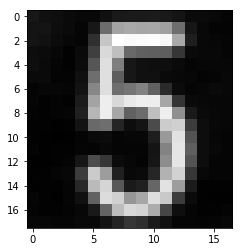

[5]
[[-1.53118762 -2.65459582 -2.85644018 -2.08305613 -3.07354907  1.02856253
  -2.18215911 -3.07853159 -1.33991484 -0.25187276]]
31.0


In [4]:
newimg = cv.imread('images/test_run2/big/imageFromWeb_008.jpg',0)
zahl = newimg[235:253,268:285]
plt.imshow(zahl,'gray')
plt.show()
thresh = cv.resize(zahl,(20,20))
desk = deskew(thresh)
hData = hog(desk)
tData = np.float32(hData).reshape(-1,bin_n*4)
pred = clf.predict(tData)
des = clf.decision_function(tData)
print(pred)
print(des)
print(np.median(thresh[0]))

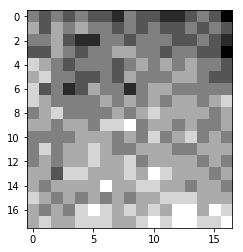

[4]
[[-1.53118762 -2.65459582 -2.85644018 -2.08305613 -3.07354907  1.02856253
  -2.18215911 -3.07853159 -1.33991484 -0.25187276]]
199.0


In [5]:
newimg = cv.imread('images/test_run2/big/imageFromWeb_008.jpg',0)
zahl = newimg[135:153,168:185]
plt.imshow(zahl,'gray')
plt.show()
thresh = cv.resize(zahl,(20,20))
desk = deskew(thresh)
hData = hog(desk)
tData = np.float32(hData).reshape(-1,bin_n*4)
pred = clf.predict(tData)
print(pred)
print(des)
print(np.median(thresh[0]))